In [3]:
import cv2
import numpy as np
from keras.models import load_model
from datetime import datetime
import time

def load_emotion_model(model_path):
    """Load and return the emotion detection model."""
    try:
        model_path = 'Best_model.keras'
        model = load_model(model_path)
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None

def initialize_camera(camera_id=0, width=640, height=480):
    """Initialize and configure the camera."""
    cap = cv2.VideoCapture(camera_id)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, width)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, height)
    if not cap.isOpened():
        raise RuntimeError("Error: Could not open camera")
    return cap

def process_frame(frame, face_cascade, model, emotion_labels):
    """Process a single frame and detect emotions."""
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE
    )
    
    for (x, y, w, h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (48, 48))
        roi = roi / 255.0
        roi = np.expand_dims(np.expand_dims(roi, axis=0), axis=-1)
        
        prediction = model.predict(roi, verbose=0)
        emotion_idx = np.argmax(prediction)
        emotion = emotion_labels[emotion_idx]
        confidence = float(prediction[0][emotion_idx] * 100)
        
        color = get_emotion_color(emotion)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
        
        label = f"{emotion}: {confidence:.1f}%"
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
        cv2.rectangle(frame, (x, y-label_size[1]-10), (x+label_size[0], y), color, -1)
        cv2.putText(frame, label, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    return frame, len(faces)

def get_emotion_color(emotion):
    """Return color based on emotion."""
    color_dict = {
        'Angry': (0, 0, 255),      # Red
        'Disgust': (0, 255, 0),    # Green
        'Fear': (128, 0, 128),     # Purple
        'Happy': (255, 255, 0),    # Yellow
        'Sad': (255, 0, 0),        # Blue
        'Surprise': (0, 255, 255), # Cyan
        'Neutral': (128, 128, 128) # Gray
    }
    return color_dict.get(emotion, (255, 255, 255))

def add_overlay_info(frame, fps, face_count):
    """Add FPS and face count overlay to frame."""
    cv2.putText(frame, f"FPS: {fps:.1f}", (10, 30), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    cv2.putText(frame, f"Faces: {face_count}", (10, 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    cv2.putText(frame, timestamp, (10, frame.shape[0]-10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)

def main():
    """Main function to run emotion detection."""
    model_path = 'Best_model.keras'
    model = load_emotion_model(model_path)
    if model is None:
        return
    
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    face_cascade_path = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(face_cascade_path)
    
    try:
        cap = initialize_camera()
    except RuntimeError as e:
        print(str(e))
        return
    
    fps = 0
    frame_count = 0
    start_time = time.time()
    
    print("Press 'q' to quit, 's' to save a screenshot")
    
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Can't receive frame")
            break
        
        frame, face_count = process_frame(frame, face_cascade, model, emotion_labels)
        
        frame_count += 1
        elapsed_time = time.time() - start_time
        if elapsed_time > 1:
            fps = frame_count / elapsed_time
            frame_count = 0
            start_time = time.time()
        
        add_overlay_info(frame, fps, face_count)
        
        cv2.imshow('Emotion Detection', frame)
        
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
        elif key == ord('s'):
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            screenshot_path = f"emotion_detection_{timestamp}.jpg"
            cv2.imwrite(screenshot_path, frame)
            print(f"Screenshot saved as {screenshot_path}")
    
    cap.release()
    cv2.destroyAllWindows()

if __name__ == "__main__":
    main()


Model loaded successfully!
Press 'q' to quit, 's' to save a screenshot


Model loaded successfully!


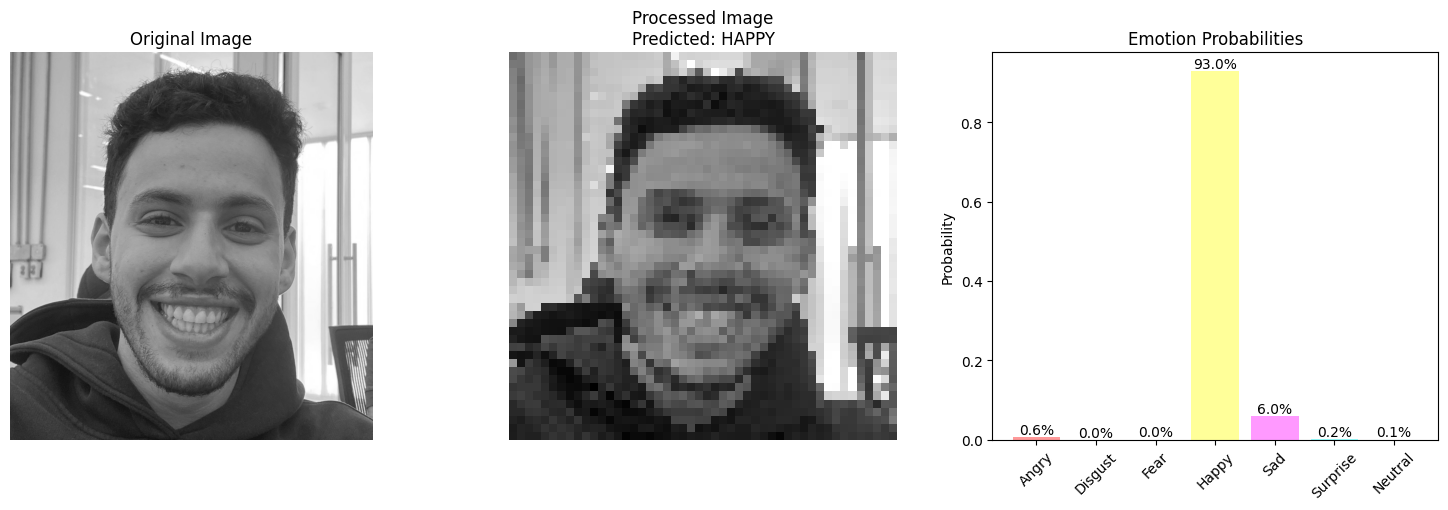


Emotion Analysis:
Predicted Emotion: HAPPY

Probability Distribution:
Happy     : ██████████████████████████████████████████████░░░░ 93.02%
Sad       : ██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 5.99%
Angry     : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.64%
Surprise  : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.23%
Neutral   : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.06%
Fear      : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.04%
Disgust   : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.02%


In [4]:
import cv2
import numpy as np
from keras.models import load_model
from datetime import datetime
import time

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_emotion_detailed(image_path, model):
    """Analyze and visualize emotion predictions for a single image."""
    # Load and preprocess the image
    orig_img = cv2.imread(image_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    img = image.load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='gray')
    plt.title(f'Processed Image\nPredicted: {predicted_emotion.upper()}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    colors = ['#FF9999', '#99FF99', '#9999FF', '#FFFF99', '#FF99FF', '#99FFFF', '#FFCC99']
    bars = plt.bar(emotion_labels, prediction[0], color=colors)
    plt.title('Emotion Probabilities')
    plt.xticks(rotation=45)
    plt.ylabel('Probability')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.1f}%',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print("\nEmotion Analysis:")
    print("=" * 50)
    print(f"Predicted Emotion: {predicted_emotion.upper()}")
    print("=" * 50)
    print("\nProbability Distribution:")
    
    emotion_probs = list(zip(emotion_labels, prediction[0]))
    emotion_probs.sort(key=lambda x: x[1], reverse=True)
    
    for emotion, prob in emotion_probs:
        bars = int(prob * 50)
        bar_chart = '█' * bars + '░' * (50 - bars)
        print(f"{emotion.ljust(10)}: {bar_chart} {prob*100:.2f}%")
    
    return predicted_emotion, prediction[0]
from keras.models import load_model

# Load the model first
model_path = 'Best_model.keras'
model = load_model(model_path)
print("Model loaded successfully!")
emotion, probs = predict_emotion_detailed('image.jpg', model)

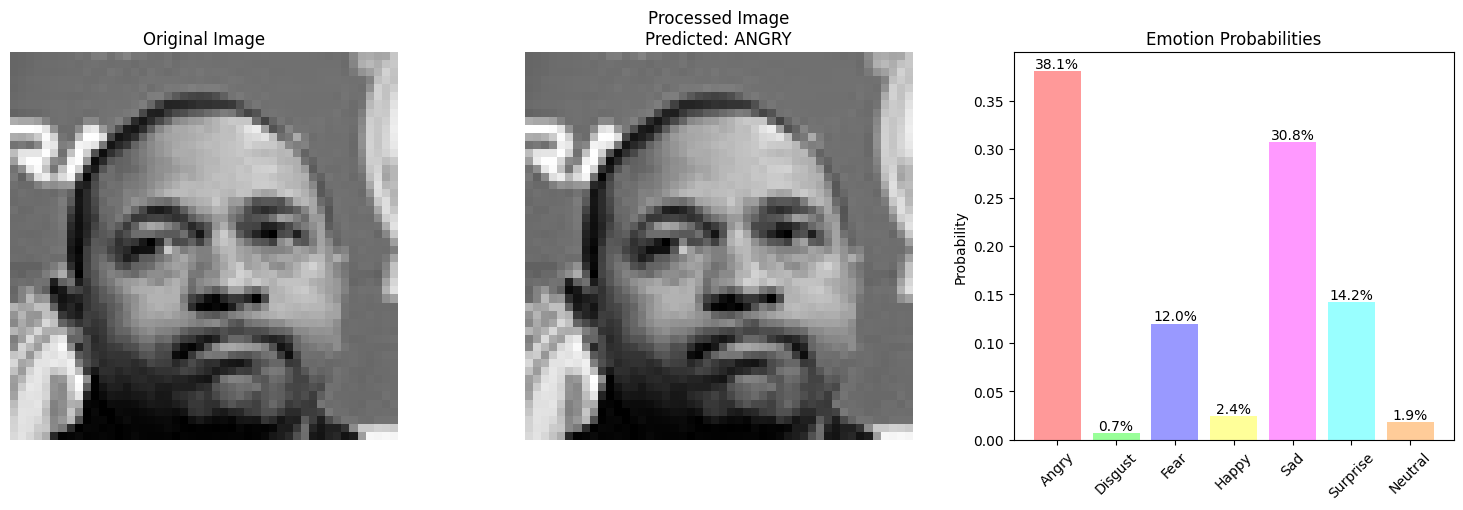


Emotion Analysis:
Predicted Emotion: ANGRY

Probability Distribution:
Angry     : ███████████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 38.08%
Sad       : ███████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 30.75%
Surprise  : ███████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 14.22%
Fear      : █████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 11.98%
Happy     : █░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 2.44%
Neutral   : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 1.86%
Disgust   : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.66%


In [5]:
import cv2
import numpy as np
from keras.models import load_model
from datetime import datetime
import time

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_emotion_detailed(image_path, model):
    """Analyze and visualize emotion predictions for a single image."""
    # Load and preprocess the image
    orig_img = cv2.imread(image_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    img = image.load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='gray')
    plt.title(f'Processed Image\nPredicted: {predicted_emotion.upper()}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    colors = ['#FF9999', '#99FF99', '#9999FF', '#FFFF99', '#FF99FF', '#99FFFF', '#FFCC99']
    bars = plt.bar(emotion_labels, prediction[0], color=colors)
    plt.title('Emotion Probabilities')
    plt.xticks(rotation=45)
    plt.ylabel('Probability')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.1f}%',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print("\nEmotion Analysis:")
    print("=" * 50)
    print(f"Predicted Emotion: {predicted_emotion.upper()}")
    print("=" * 50)
    print("\nProbability Distribution:")
    
    emotion_probs = list(zip(emotion_labels, prediction[0]))
    emotion_probs.sort(key=lambda x: x[1], reverse=True)
    
    for emotion, prob in emotion_probs:
        bars = int(prob * 50)
        bar_chart = '█' * bars + '░' * (50 - bars)
        print(f"{emotion.ljust(10)}: {bar_chart} {prob*100:.2f}%")
    
    return predicted_emotion, prediction[0]

emotion, probs = predict_emotion_detailed('test\sad\PublicTest_94626374.jpg', model)

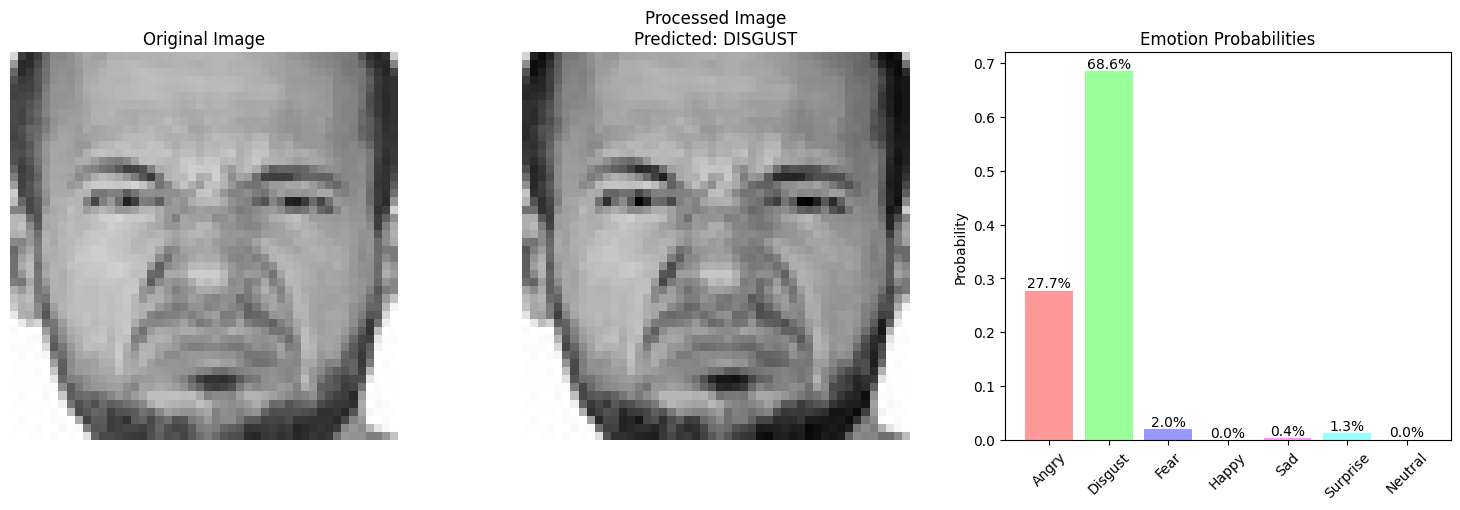


Emotion Analysis:
Predicted Emotion: DISGUST

Probability Distribution:
Disgust   : ██████████████████████████████████░░░░░░░░░░░░░░░░ 68.58%
Angry     : █████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 27.73%
Fear      : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 1.99%
Surprise  : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 1.28%
Sad       : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.38%
Neutral   : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.03%
Happy     : ░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.00%


In [6]:
import cv2
import numpy as np
from keras.models import load_model
from datetime import datetime
import time

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_emotion_detailed(image_path, model):
    """Analyze and visualize emotion predictions for a single image."""
    # Load and preprocess the image
    orig_img = cv2.imread(image_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    img = image.load_img(image_path, color_mode='grayscale', target_size=(48, 48))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Make prediction
    prediction = model.predict(img_array, verbose=0)
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    predicted_emotion = emotion_labels[np.argmax(prediction)]
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(img, cmap='gray')
    plt.title(f'Processed Image\nPredicted: {predicted_emotion.upper()}')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    colors = ['#FF9999', '#99FF99', '#9999FF', '#FFFF99', '#FF99FF', '#99FFFF', '#FFCC99']
    bars = plt.bar(emotion_labels, prediction[0], color=colors)
    plt.title('Emotion Probabilities')
    plt.xticks(rotation=45)
    plt.ylabel('Probability')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height*100:.1f}%',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis
    print("\nEmotion Analysis:")
    print("=" * 50)
    print(f"Predicted Emotion: {predicted_emotion.upper()}")
    print("=" * 50)
    print("\nProbability Distribution:")
    
    emotion_probs = list(zip(emotion_labels, prediction[0]))
    emotion_probs.sort(key=lambda x: x[1], reverse=True)
    
    for emotion, prob in emotion_probs:
        bars = int(prob * 50)
        bar_chart = '█' * bars + '░' * (50 - bars)
        print(f"{emotion.ljust(10)}: {bar_chart} {prob*100:.2f}%")
    
    return predicted_emotion, prediction[0]

emotion, probs = predict_emotion_detailed(r"test\disgust\PrivateTest_22382996.jpg", model)


In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 44, 44, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 20, 20, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 18, 18, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 7, 7, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 5, 5, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,178,071 (15.94 MB)

 Trainable params: 1,391,943 (5.31 MB)

 Non-trainable params: 2,240 (8.75 KB)

 Optimizer params: 2,783,888 (10.62 MB)